Prototype implementation of FE for solids and fluids

\begin{equation}
    [M]\frac{U_{t+1}-2U_{t}+U_{t-1}}{\delta t^2}+[C]\frac{U_{t+1}-U_{t-1}}{2\delta t}+[K]U_t =  F,
\end{equation}
and re-arranging arrive at

\begin{equation}
    \left([M]\frac{1}{\delta t^2}+[C]\frac{1}{2\delta t}\right)U_{t+1} = F + \left([M]\frac{2}{\delta t^2}-[K]\right)U_t + \left([C] \frac{1}{2 \delta t }-[M]\frac{1}{\delta t^2}\right)U_{t-1}.
\end{equation}


\begin{equation}
    U_{t+1} = F'+C'U_{t-1}+K'U_{t}
\end{equation}


\begin{equation}
K' = \left([M]\frac{1}{\delta t^2}+[C]\frac{1}{2\delta t}\right)^{-1}\left([M]\frac{2}{\delta t^2}-[K]\right)
\end{equation}


\begin{equation}
C' = \left([M]\frac{1}{\delta t^2}+[C]\frac{1}{2\delta t}\right)^{-1}\left([C] \frac{1}{2 \delta t }-[M]\frac{1}{\delta t^2}\right)
\end{equation}

\begin{equation}
    F'=\left([M]\frac{1}{\delta t^2}+[C]\frac{1}{2\delta t}\right)^{-1} F
\end{equation}


In [ ]:
import numpy as np
"""
import pogopy.generate as pg
import pogopy.model as pm
import pogopy.write as pw
import pogopy.misc as misc
from . import misc
"""

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import copy
import struct
from collections import defaultdict
from tqdm import trange

from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import inv

import time



In [ ]:
def tri3_shape_fun(nodes, eval_points):
    #this can be made simpler by simply calculation x_jk if needed.
    J = np.zeros([2,2])
    xi,eta = eval_points
    nf = np.array(
                 [(1-xi-eta),
                  (xi),
                  (eta)])
    x = nodes[:,0]
    y = nodes[:,1]
    dnxi = np.array([-1, 1 , 0])
    dneta = np.array([-1, 0 , 1])
        
    J[0,0] = dnxi @ x
    J[0,1] = dnxi @ y
    J[1,0] = dneta @ x
    J[1,1] = dneta @ y
    
    Jdet = np.linalg.det(J)
    dnx = (J[1,1]*dnxi - J[0,1]*dneta)/Jdet
    dny = (-J[1,0]*dnxi + J[0,0]*dneta)/Jdet
    
    B = np.zeros([3,6])
    B[0, ::2] = dnx
    B[1, 1::2] = dny
    B[2, ::2] = dny
    B[2, 1::2] = dnx
    
    return B, Jdet

In [ ]:
def quad4_shape_fun(nodes, eval_points):
    J = np.zeros([2,2])
    xi,eta = eval_points
    nf = 0.25*np.array(
        [(1 - xi)*(1 - eta),
         (1 + xi)*(1 - eta),
         (1 + xi)*(1 + eta),
         (1 - xi)*(1 + eta)])
    x = nodes[:,0]
    y = nodes[:,1]
    dnxi = -0.25*np.array([-(1-eta),
                            (1-eta),
                            (1+eta),
                           -(1+eta)])
    
    dneta = - 0.25*np.array([-(1-xi),
                             -(1+xi),
                              (1+xi),
                              (1-xi)])
    J[0,0] = dnxi @ x
    J[0,1] = dnxi @ y
    J[1,0] = dneta @ x
    J[1,1] = dneta @ y
    
    Jdet = np.linalg.det(J)
    dnx = (J[1,1]*dnxi - J[0,1]*dneta)/Jdet
    dny = (-J[1,0]*dnxi + J[0,0]*dneta)/Jdet
    B = np.zeros([3,8])
    B[0, ::2] = dnx
    B[1, 1::2] = dny
    B[2, ::2] = dny
    B[2, 1::2] = dnx
    #H = np.zeros([1,8])
    #H[0,::2] = dnx
    #H[0,1::2]=dny
    return B, Jdet #, H

def quadrature_simple():
    qLoc = np.array([-1/np.sqrt(3),1/np.sqrt(3)])
    qWeight = np.array([1,1])
    nQuad=2
    return qLoc, qWeight, nQuad

def calc_area(nodes):
    area = 0
    for i in range(len(nodes)):
        if (i+1<len(nodes)):
            area += 0.5*(nodes[i+1,0]+nodes[i,0])*(nodes[i+1,1]-nodes[i,1])
        else :
            area += 0.5*(nodes[0,0]+nodes[i,0])*(nodes[0,1]-nodes[i,1])
    return area

In [ ]:
nod = np.array([[0,0],[1,0],[1,1],[0,1]])

In [ ]:
    compmod = 4
    D = np.array([[compmod, compmod ,0 ],
                [compmod, compmod, 0],
                [0, 0 , 0]])
    qLoc = np.array([-1/np.sqrt(3),1/np.sqrt(3)])

    stiff_local = np.zeros([8,8])
    eval_points= np.array([0,0])
    B,det=quad4_shape_fun(nod, eval_points)
            
            
    stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det



In [ ]:
stiff_local


array([[ 0.25,  0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25],
       [ 0.25,  0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25,  0.25,  0.25, -0.25,  0.25],
       [ 0.25,  0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25,  0.25,  0.25, -0.25,  0.25],
       [-0.25, -0.25,  0.25, -0.25,  0.25,  0.25, -0.25,  0.25],
       [ 0.25,  0.25, -0.25,  0.25, -0.25, -0.25,  0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25,  0.25,  0.25, -0.25,  0.25]])

In [ ]:
stiff_local.T[[4,6]]  = stiff_local.T[[6,4]]  

In [ ]:
stiff_local.T[[5,7]]  = stiff_local.T[[7,5]]  

In [ ]:
stiff_local

array([[ 0.25,  0.25, -0.25,  0.25,  0.25, -0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25,  0.25,  0.25, -0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25,  0.25],
       [ 0.25,  0.25, -0.25,  0.25,  0.25, -0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25,  0.25],
       [ 0.25,  0.25, -0.25,  0.25,  0.25, -0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25, -0.25, -0.25,  0.25,  0.25,  0.25]])

In [ ]:
from scipy import io

mat = io.loadmat('/home/ys1818/OneDrive/objects/4fluidfullabs.mat')
force = io.loadmat('/home/ys1818/OneDrive/objects/4quadforcefullabs.mat')


In [ ]:
tone=force['force'].transpose()

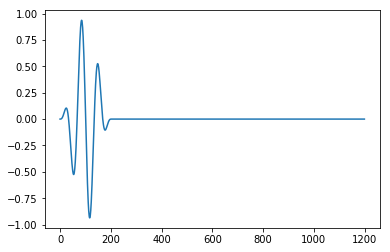

In [ ]:
plt.plot(tone)
plt.show()

In [ ]:
def quadrature_simple3():
    qLoc = np.array([1/3,1/3])
    qWeight = np.array([1/2])
    nQuad =1
    return qLoc, qWeight, nQuad

def quadrature_simple():
    qLoc = np.array([-1/np.sqrt(3),1/np.sqrt(3)])
    qWeight = np.array([1,1])
    nQuad=2
    return qLoc, qWeight, nQuad

In [ ]:
def four_node(el_num,nodes,connectivity_matrix,global_stiff,global_mass,global_damping,count,E=1,nu=0,rho=1,alpha=0):
    area = calc_area(nodes)
    
    #D comes from the model params, CPE4R implementation here
    
    
    D = np.array([[1-nu, nu ,0 ],
                [nu, 1-nu, 0],
                [0, 0 , 0.5*(1-2*nu)]])
    
    D = E/(1+nu)/(1-2*nu)*D
    
    stiff_local = np.zeros([8,8])

    Ji = np.zeros([2,2])
    VecI = np.zeros([2,1])
    Vec0 = np.zeros([2,1])
    xiCoords = np.array([-1, 1, 1, -1])
    etaCoords = np.array([-1, -1, 1, 1])
    

    qLoc = np.array([-1/np.sqrt(3),1/np.sqrt(3)])
    
    for i_i in range(2):
        for j_j in range(2):
            eval_points = np.array([qLoc[i_i],qLoc[j_j]])
            B,det=quad4_shape_fun(nodes, eval_points)
            
            
            stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det

            #area = area + abs(det)*allweight
            #stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det*allweight
    
    
    
    for i in range(4):
        first=connectivity_matrix[el_num][i]
        global_mass[first*2]+=area*0.25*rho
        global_mass[first*2+1]+=area*0.25*rho
        global_damping[first*2,first*2]+=area*0.25*rho*alpha
        global_damping[first*2+1,first*2+1]+=area*0.25*rho*alpha
        #mass and damping should go here. As we need each node contribution
        for j in range(4):
            second = connectivity_matrix[el_num][j]
            global_stiff[first*2,second*2]+=stiff_local[i*2,j*2] #this needs to be +=
            global_stiff[first*2,second*2+1]+=stiff_local[i*2,j*2+1]
            global_stiff[first*2+1,second*2]+=stiff_local[i*2+1,j*2]
            global_stiff[first*2+1,second*2+1]+=stiff_local[i*2+1,j*2+1]
            count = count+1
    
    return global_stiff,global_mass,global_damping,count
    


In [ ]:
def four_node_fluid(el_num,nodes,connectivity_matrix,global_stiff,global_mass,global_damping,count,compmod=1,visc=1,rho=1,alpha=1):
    area = calc_area(nodes)
    
    #D comes from the model params, CPE4R implementation here
    
    
    D = compmod*np.array([[1, 1 ,0 ],
                [1, 1, 0],
                [0, 0 , 0]])
    
    
    Dvisc = visc*np.array([[-4/3, 2/3 ,0 ],
                [2/3, -4/3, 0],
                [0, 0 , -1]])
    
    
    Dinvisc = visc*np.array([[0, 0 ,0 ],
                [0, 0, 0],
                [0, 0 , -1]])
    
    
    stiff_local = np.zeros([8,8])
    damping_local = np.zeros([8,8])

    qLoc = np.array([-1/np.sqrt(3),1/np.sqrt(3)])
    
    for i_i in range(2):
        for j_j in range(2):
            eval_points = np.array([qLoc[i_i],qLoc[j_j]])
            B,det=quad4_shape_fun(nodes, eval_points)
            
            
            stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det
            damping_local = damping_local + B.transpose().dot(Dinvisc).dot(B)*det

    
    #eval_points = np.array([0,0])
    #B,det=quad4_shape_fun(nodes, eval_points)
    

            #area = area + abs(det)*allweight
            #stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det*allweight
    
    damping_local = 1000*damping_local #might need changing
    
    for i in range(4):
        first=connectivity_matrix[el_num][i]
        global_mass[first*2]+=area*0.25*rho
        global_mass[first*2+1]+=area*0.25*rho
        #mass and damping should go here. As we need each node contribution
        for j in range(4):
            
            second = connectivity_matrix[el_num][j]
            global_stiff[first*2,second*2]+=stiff_local[i*2,j*2] #this needs to be +=
            global_stiff[first*2,second*2+1]+=stiff_local[i*2,j*2+1]
            global_stiff[first*2+1,second*2]+=stiff_local[i*2+1,j*2]
            global_stiff[first*2+1,second*2+1]+=stiff_local[i*2+1,j*2+1]
            global_damping[first*2,second*2]+=damping_local[i*2,j*2] #this needs to be +=
            global_damping[first*2,second*2+1]+=damping_local[i*2,j*2+1]
            global_damping[first*2+1,second*2]+=damping_local[i*2+1,j*2]
            global_damping[first*2+1,second*2+1]+=damping_local[i*2+1,j*2+1]
            
            count = count+1
    
    return global_stiff,global_mass,global_damping,count
    


In [ ]:
def three_node(el_num,nodes,connectivity_matrix,global_stiff,global_mass,global_damping,count,E=1,nu=0,rho=1,alpha=0):
    area = calc_area(nodes)
    
    #D comes from the model params, CPE4R implementation here
    
    
    D = np.array([[1-nu, nu ,0 ],
                [nu, 1-nu, 0],
                [0, 0 , 0.5*(1-2*nu)]])
    
    D = E/(1+nu)/(1-2*nu)*D
    
    stiff_local = np.zeros([6,6])

    qLoc = np.array([1/3,1/3])
    
    B,det= tri3_shape_fun(nodes, qLoc)
                    
    stiff_local = stiff_local + (1/(4*area))*B.transpose().dot(D).dot(B)

            #area = area + abs(det)*allweight
            #stiff_local = stiff_local + B.transpose().dot(D).dot(B)*det*allweight
    
    for i in range(3):
        first=connectivity_matrix[el_num][i]
        global_mass[first*2]+=area*0.25*rho
        global_mass[first*2+1]+=area*0.25*rho
        global_damping[first*2]+=area*0.25*rho*alpha
        global_damping[first*2+1]+=area*0.25*rho*alpha
        #mass and damping should go here. As we need each node contribution
        for j in range(3):
            second = connectivity_matrix[el_num][j]
            global_stiff[first*2,second*2]+=stiff_local[i*2,j*2] #this needs to be +=
            global_stiff[first*2,second*2+1]+=stiff_local[i*2,j*2+1]
            global_stiff[first*2+1,second*2]+=stiff_local[i*2+1,j*2]
            global_stiff[first*2+1,second*2+1]+=stiff_local[i*2+1,j*2+1]
            count = count+1
    
    return global_stiff,global_mass,global_damping,count
    

In [ ]:
def assemble_sparse(mat,sparse_flag=True):
    
    dofs = mat['nDims'][0][0]
    nodePos=mat['nodePos'].transpose()
    
    elNodes= mat['elNodes'].transpose()-1 # connectivity
    elTypeRefs = mat['elTypeRefs']-1
    num_node = len(nodePos)
    matTypeRefs = mat['matTypeRefs']-1
    elTypes = mat['elTypes']


    
    stiff_global = lil_matrix((dofs*num_node,dofs*num_node))
    
    mass_global = np.zeros([dofs*num_node])
    damping_global = lil_matrix((dofs*num_node,dofs*num_node))
    
    count = 0
    #need to deal with awkward Pogo format here, Dispatch based on triangular element, rectangular element or with damping
    for el_num,el in enumerate(elNodes):
        matRef = matTypeRefs[el_num][0] #to access the value, not the array.
        elRef = elTypeRefs[el_num][0]
        elType = elTypes[elRef][0][0][0][0][0]
        if elType == 'CPE4RF':
            if len(mat['matTypes'][0][matRef][0][0][1][0])==3:
                E,nu,rho = mat['matTypes'][0][matRef][0][0][1][0]
                nodes = nodePos[el]
                stiff_global,mass_global,damping_global,count = four_node_fluid(el_num,nodes,elNodes,stiff_global,mass_global,damping_global,count,E,nu,rho,0)        
            if len(mat['matTypes'][0][matRef][0][0][1][0])==4:
                E,nu,rho,alpha = mat['matTypes'][0][matRef][0][0][1][0]
                nodes = nodePos[el]
                stiff_global,mass_global,damping_global,count = four_node_fluid(el_num,nodes,elNodes,stiff_global,mass_global,damping_global,count,E,nu,rho,alpha)        
        else:
            if len(mat['matTypes'][0][matRef][0][0][1][0])==3:
                E,nu,rho = mat['matTypes'][0][matRef][0][0][1][0]
                nodes = nodePos[el]
                stiff_global,mass_global,damping_global,count = four_node(el_num,nodes,elNodes,stiff_global,mass_global,damping_global,count,E,nu,rho,0)        
            if len(mat['matTypes'][0][matRef][0][0][1][0])==4:
                E,nu,rho,alpha = mat['matTypes'][0][matRef][0][0][1][0]
                nodes = nodePos[el]
                stiff_global,mass_global,damping_global,count = four_node(el_num,nodes,elNodes,stiff_global,mass_global,damping_global,count,E,nu,rho,alpha)        

    #if sparse_flag ==True, convert these to csr format for faster calculations
    if sparse_flag:
      stiff_global.tocsr()
      damping_global.tocsr()
    return stiff_global, mass_global, damping_global

In [ ]:
start = time.time()
K,M,C = assemble_sparse(mat)
end = time.time()
print(end - start)


206.04905605316162


In [ ]:
displacement = np.zeros([K.shape[0],tone.shape[0]]) #this needs to be with the proper timestepping.

In [ ]:
forcing = np.zeros([K.shape[0],tone.shape[0]]) #this needs to be with the proper timestepping.

In [ ]:
source_locations = io.loadmat('/home/ys1818/OneDrive/objects/source_locations.mat')


array([80341])

In [ ]:
amps = io.loadmat('/home/ys1818/OneDrive/objects/amps.mat')


array([1.9, 2.2])

In [ ]:
def create_force(forcing,source_locations,amps,tone):
    for i,j in enumerate(source_locations):
        forcing[j*2,:] = tone.transpose()*amps[i*2]
        print(amps[i*2])
        forcing[j*2+1,:] = tone.transpose()*amps[i*2+1]
        print(amps[i*2+1])
    return forcing

In [ ]:
forcing = create_force(forcing,source_locations,amps,tone)

1.9
2.2


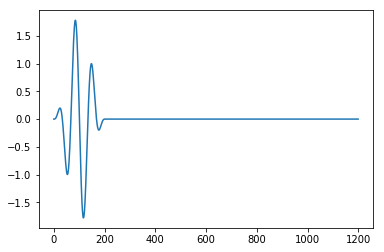

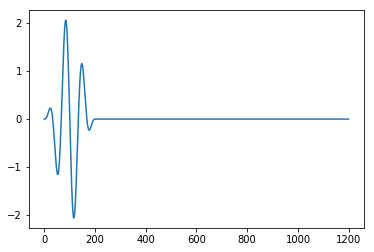

In [ ]:
for i,j in enumerate(source_locations):
    plt.figure()
    plt.plot(forcing[j*2,:])
    plt.figure()
    plt.plot(forcing[j*2+1,:])

In [ ]:
for t_step in range(forcing.shape[1]-2):
    displacement[:,t_step+2]= (dt*dt)*M_inv@(forcing[:,t_step+1]-K@displacement[:,t_step+1])+2*displacement[:,t_step+1]-displacement[:,t_step]+dt*M_inv@C@(displacement[:,t_step]-displacement[:,t_step+1])


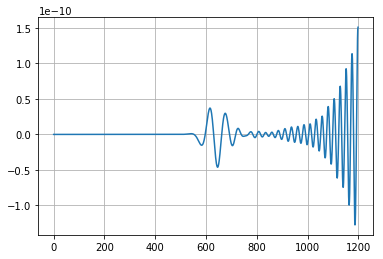

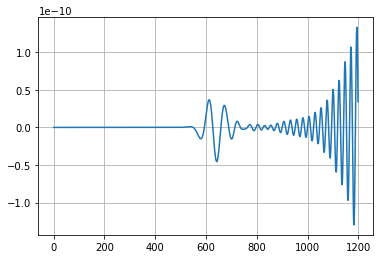

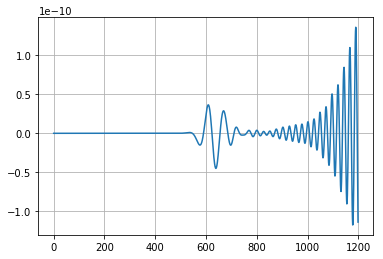

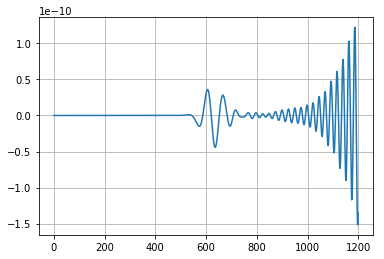

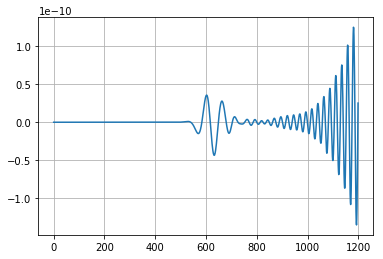

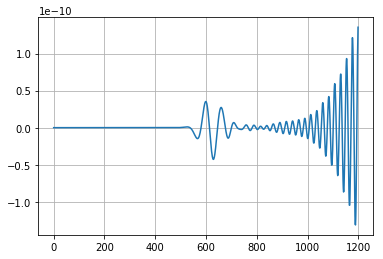

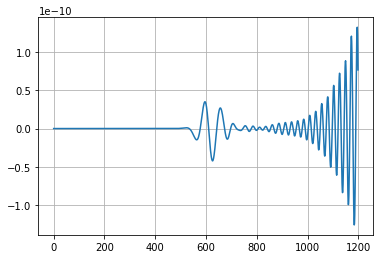

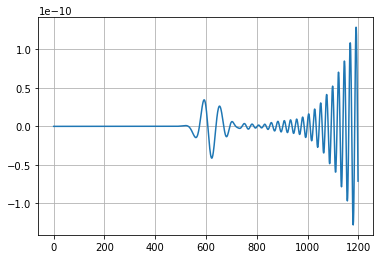

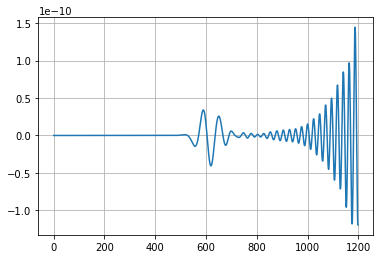

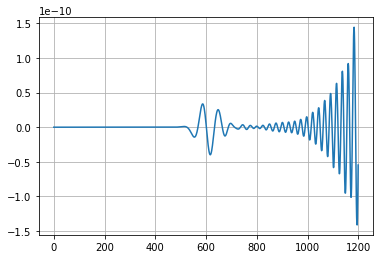

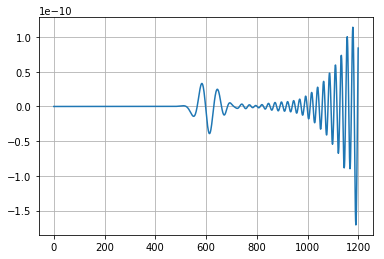

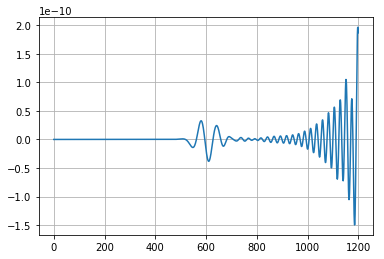

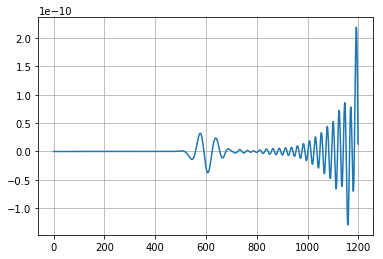

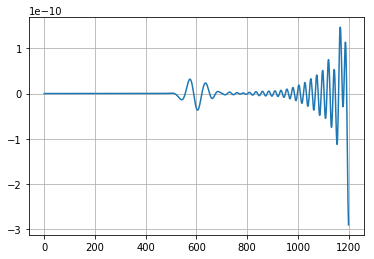

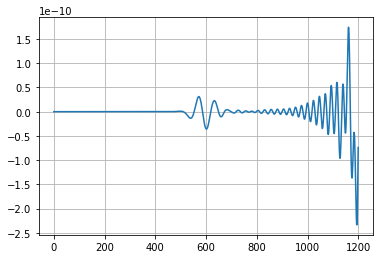

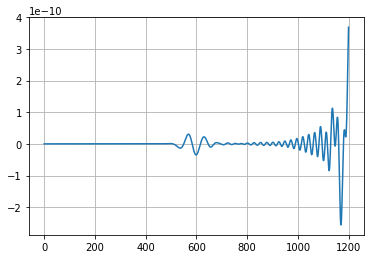

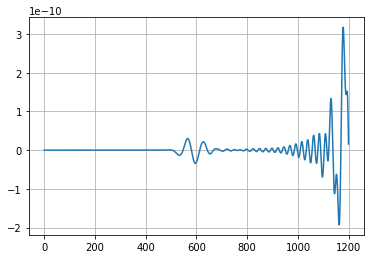

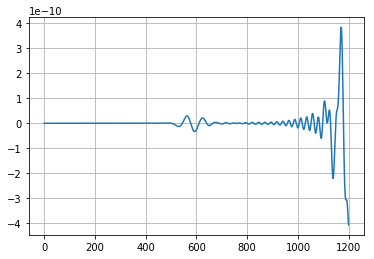

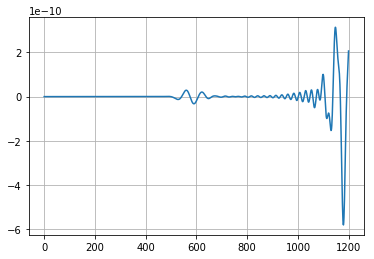

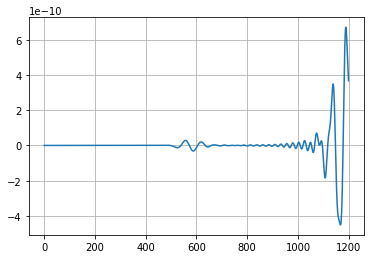

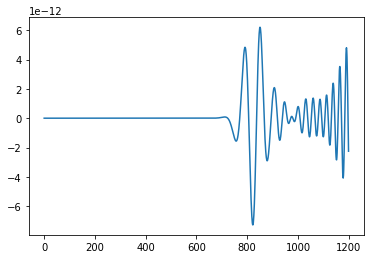

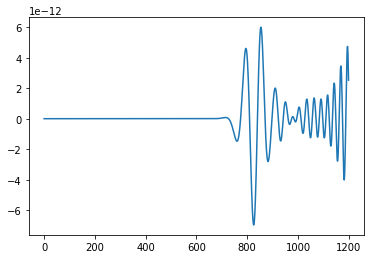

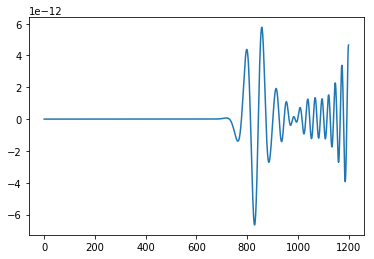

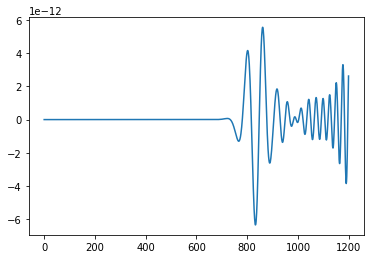

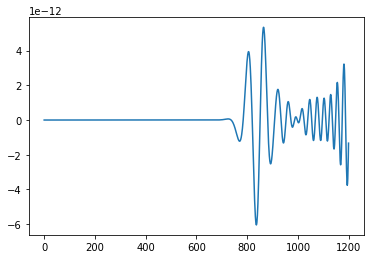

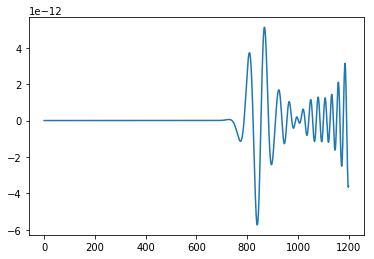

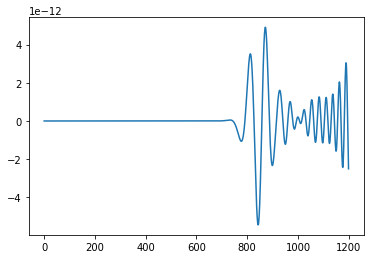

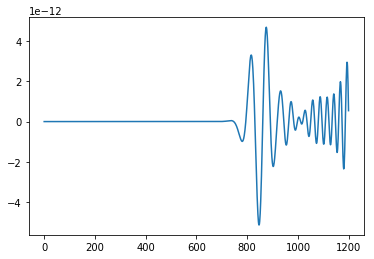

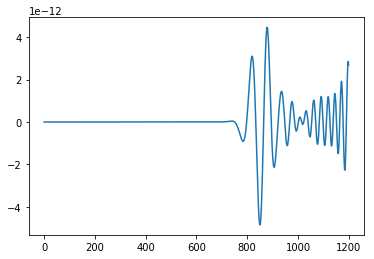

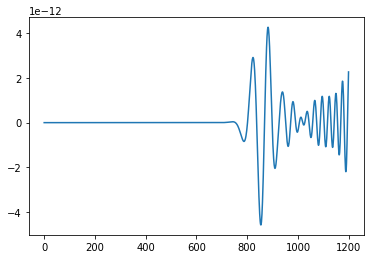

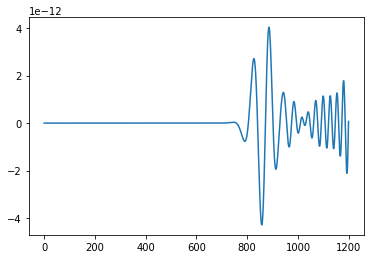

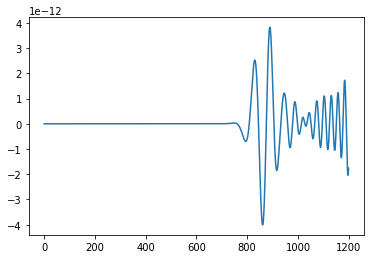

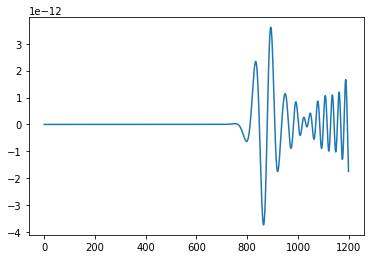

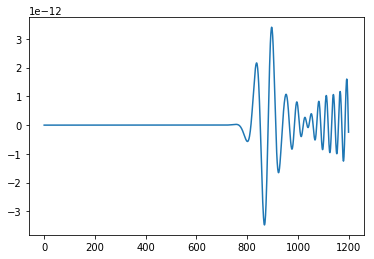

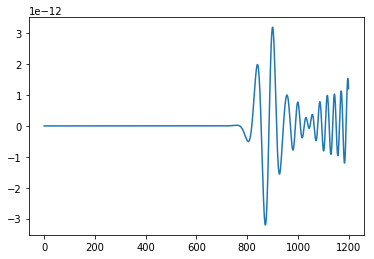

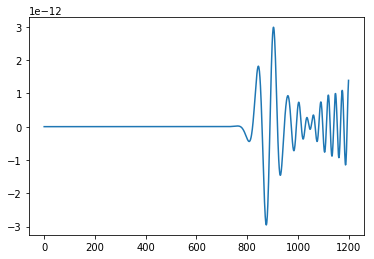

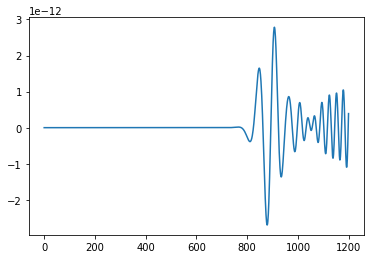

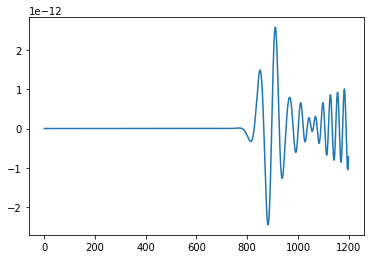

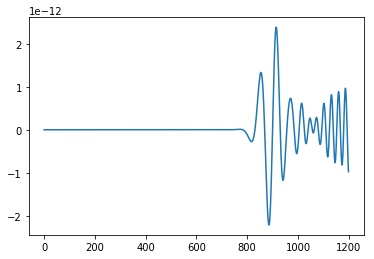

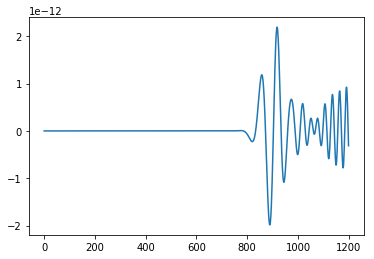

In [ ]:
for i in range(40330,40330+20):
    plt.figure()
    
    plt.plot(displacement[i*2+1,:])

In [ ]:
#connectivity graph assembly, no longer needed as the mesh format provides it
def create_connectivity(conn_array):
    connectivity_graph=np.zeros([len(np.unique(conn_array)),len(np.unique(conn_array))])
    for element in conn_array:
        for index,node in enumerate(element):
            connectivity_graph[node,element[index]]=1
            connectivity_graph[node,element[(index+1)%4]]=1
            connectivity_graph[node,element[(index+2)%4]]=1
            connectivity_graph[node,element[(index+3)%4]]=1

            #print((node-element[index%4]))
    return connectivity_graph
